**<font color = black size=6>实验五：支持向量机</font>**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import cvxopt
from cvxopt import matrix
from cvxopt import solvers

**<font color = blue size=4>第一部分:函数介绍</font>**

二次规划问题是形式如下的一类最优化问题：
$$
\begin{align}
\min_x \quad  &\frac{1}{2}x^TPx+q^Tx \\
s.t. \quad  &Gx\leq h \\
      &Ax=b
\end{align}
$$
对于这一类问题可以使用[cvxopt](https://cvxopt.org/userguide/coneprog.html#quadratic-programming)库的solvers.qp()函数进行求解。

以下是一个例子（参考[Solving a quadratic program](https://cvxopt.org/examples/tutorial/qp.html)）:
$$
\begin{align}
\min_x \quad  &2x_1^2+x_2^2+x_1x_2+x_1+x_2 \\
s.t. \quad  &x_1\geq 0 \\
      &x_2\geq 0 \\
      &x_1+x_2=1
\end{align}
$$
为了使用solvers.qp()函数，我们需要知道在该二次规划问题中的$P,q,G,h,A,b$矩阵分别是什么。
在该优化问题中，

* $P:=\begin{bmatrix}
    4 & 1 \\ 1 & 2
   \end{bmatrix}$,
* $q:=\begin{bmatrix}
    1 \\ 1
   \end{bmatrix}$,
* $G:=\begin{bmatrix}
    -1 & 0 \\ 0 & -1
   \end{bmatrix}$,
* $h:=\begin{bmatrix}
    0 \\ 0
   \end{bmatrix}$,
* $A:=\begin{bmatrix}
    1 & 1
   \end{bmatrix}$,
* $b:=\begin{bmatrix}
    1
   \end{bmatrix}$,
   
把这些参数送入solvers.qp()函数中即可求出解。

In [3]:
# Tips1: cvxopt库中的matrix只接受double类型的数据
# Tips2: matrix使用列表作为参数创建矩阵和numpy.array使用列表作为参数创建矩阵是不同的
# print(matrix([[1.0, 1.0]]))
# print(np.array([[1.0, 1.0]]))
# print(matrix(np.array([[1.0, 1.0]])))
Q = 2*matrix([ [2, .5], [.5, 1] ])
p = matrix([1.0,1.0])
G = matrix([[-1.0,0.0],[0.0,-1.0]])
h = matrix([0.0,0.0])
A = matrix([1.0, 1.0], (1,2))
b = matrix(1.0)
sol=solvers.qp(Q, p, G, h, A, b)
print(sol['x'])

     pcost       dcost       gap    pres   dres
 0:  1.8889e+00  7.7778e-01  1e+00  2e-16  2e+00
 1:  1.8769e+00  1.8320e+00  4e-02  1e-16  6e-02
 2:  1.8750e+00  1.8739e+00  1e-03  2e-16  5e-04
 3:  1.8750e+00  1.8750e+00  1e-05  1e-16  5e-06
 4:  1.8750e+00  1.8750e+00  1e-07  3e-16  5e-08
Optimal solution found.
[ 2.50e-01]
[ 7.50e-01]



**<font color = blue size=4>第二部分:实验任务</font>**

1.线性可分支持向量机与硬间隔最大化

<span style="color:purple">1) 读入数据集'dataset1.csv',把数据类型都转换成np.double类型，并画出数据集的散点图，给正样本（y为+1）和负样本（y为-1）分别标上不同的颜色。</span>

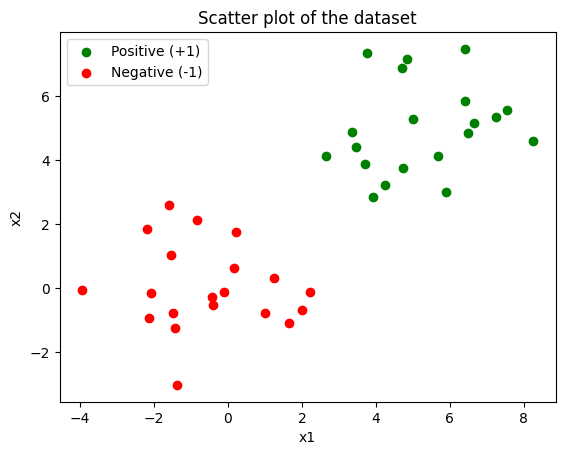

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxopt
from cvxopt import matrix
from cvxopt import solvers
# 1) 读入数据集
data = pd.read_csv('dataset1.csv')
X = data[['x1', 'x2']].values.astype(np.double)
y = data['y'].values.astype(np.double)
# 画出数据集的散点图
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='g', label='Positive (+1)')
plt.scatter(X[y == -1, 0], X[y == -1, 1], c='r', label='Negative (-1)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Scatter plot of the dataset')
plt.legend()
plt.show()


<span style="color:purple">2) 求解如下对偶问题（参考课件）：</span>
$$
\begin{align}
\min_\alpha \quad  &\frac{1}{2}\sum_{i=1}^m\sum_{j=1}^m\alpha_i\alpha_jy_iy_j\pmb{x}_i^T\pmb{x}_j-\sum_{i=1}^m\alpha_i \\
s.t. \quad  &\sum_{i=1}^m\alpha_iy_i=0 \\
      &\pmb{\alpha}\geq \pmb{0}
\end{align}
$$

这个优化问题是一个二次规划问题。
* $P是一个m\times m的矩阵，其中P_{ij}=y_iy_j\pmb{x}_i^T\pmb{x}_j$,
* $q是一个m\times 1的所有值都为-1的列向量，即q:=\begin{bmatrix}
    -1 & -1 & \cdots & -1
   \end{bmatrix}^T$,
* $G:=\begin{bmatrix}
    -1 & 0 & \cdots & 0 \\
    0 & -1 & \cdots & 0 \\
   \vdots & \vdots & \ddots &0 \\
   0 & 0 & 0 & -1
   \end{bmatrix}_{m\times m}=-\pmb{I},\pmb{I}为单位矩阵,$
* $h是一个m\times 1的零向量,即h:=\begin{bmatrix}
    0 & 0 & \cdots & 0
   \end{bmatrix}^T$,
* $A:=\begin{bmatrix}
    y_1 & y_2 & \cdots & y_m
   \end{bmatrix}^T$,
* $b:=\begin{bmatrix}
    0
   \end{bmatrix},一个标量$
   
<span style="color:purple">把上述参数送入求解器solvers.qp()中即可得到最优解$\alpha^*$</span>。 
 
附：$P$矩阵的一个计算方法：
设$X=\begin{bmatrix}
    x_{11} & x_{12} \\
    x_{21} & x_{22} \\
    \vdots & \vdots \\
    x_{m1} & x_{m2}
   \end{bmatrix}$,
   $Y=\begin{bmatrix}
    y_{1} \\
    y_{2} \\
    \vdots \\
    y_{m}
   \end{bmatrix}$,
   
计算$X'=\begin{bmatrix}
    x_{11}y_1 & x_{12}y_1 \\
    x_{21}y_2 & x_{22}y_2 \\
    \vdots & \vdots \\
    x_{m1}y_m & x_{m2}y_m
   \end{bmatrix}=X*Y(注意这里是星乘)$
   
则$P=X'X'^T$。

In [8]:
# 2) 求解对偶问题
m = len(y)
Xy = X * y[:, np.newaxis]
P = matrix(Xy @ Xy.T)
q = matrix(-np.ones((m, 1)))
G = matrix(-np.eye(m))
h = matrix(np.zeros((m, 1)))
A = matrix(y.reshape(1, -1))
b = matrix(0.0)

# 调用求解器
sol = solvers.qp(P, q, G, h, A, b)
alpha = np.array(sol['x'])

     pcost       dcost       gap    pres   dres
 0: -5.2553e+00 -9.0147e+00  1e+02  1e+01  2e+00
 1: -4.9265e+00 -1.9551e+00  2e+01  2e+00  3e-01
 2: -1.5759e-01 -3.1831e-01  7e-01  4e-02  7e-03
 3: -1.3147e-01 -1.9706e-01  7e-02  2e-17  8e-16
 4: -1.7378e-01 -1.8099e-01  7e-03  1e-16  9e-16
 5: -1.7979e-01 -1.8010e-01  3e-04  5e-17  1e-15
 6: -1.8003e-01 -1.8003e-01  3e-06  4e-17  7e-16
 7: -1.8003e-01 -1.8003e-01  3e-08  4e-17  8e-16
Optimal solution found.


<span style="color:purple">3) 求出$\pmb{\omega}^*=\sum_{i=1}^m\alpha_i^*y_i\pmb{x}_i$和$b^*=y_j-\pmb{\omega}^{*T}\pmb{x_j}$, 其中$j$为$\alpha^*$中的一个正分量$\alpha_j^*>0$的下标。注意：由于求解器求出来的是一个近似解，所以$\alpha^*$中很多实际上为0的分量会略大于0，这时候可以设置一个阈值把非常靠近0的那些分量筛去，再从剩下的分量中选取一个正分量来计算$b^*$,或者也可以直接取$\alpha^*$中最大的分量来计算$b^*$。</span>

In [6]:
# 3) 计算 𝜔 和 𝑏
w = np.sum(alpha * y[:, None] * X, axis=0)
b = y[np.argmax(alpha)] - np.dot(X[np.argmax(alpha)], w)
print(w)
print(b)

[0.40821121 0.43979838]
-1.8556819838183283


<span style="color:purple">4) 画出数据集的散点图，给正样本（y为+1）和负样本（y为-1）分别标上不同的颜色，再为支持向量（训练数据中$\alpha_j^*>0$的对应的样本）标上不同的颜色，并画出决策边界$\pmb{\omega}^{*T}\pmb{x}+b=0$和间隔边界$\pmb{\omega}^{*T}\pmb{x}+b=1$与$\pmb{\omega}^{*T}\pmb{x}+b=-1$。</span>

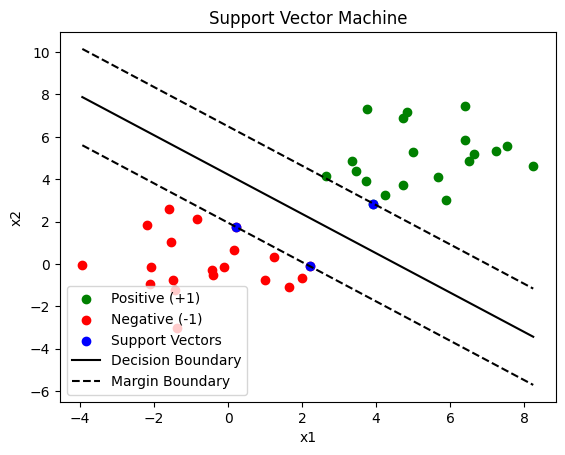

In [7]:
# 4) 画出数据集散点图和决策边界
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='g', label='Positive (+1)')
plt.scatter(X[y == -1, 0], X[y == -1, 1], c='r', label='Negative (-1)')
plt.scatter(X[alpha.flatten() > 1e-4, 0], X[alpha.flatten() > 1e-4, 1], c='b', label='Support Vectors')
x1 = np.linspace(np.min(X[:,0]), np.max(X[:,0]), 100)
x2 = (-w[0]*x1 - b) / w[1]  # 决策边界
x2_margin1 = (-w[0]*x1 - b + 1) / w[1]  # 间隔边界
x2_margin2 = (-w[0]*x1 - b - 1) / w[1]
plt.plot(x1, x2, 'k', label='Decision Boundary')
plt.plot(x1, x2_margin1, 'k--', label='Margin Boundary')
plt.plot(x1, x2_margin2, 'k--')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Support Vector Machine')
plt.legend()
plt.show()

2.线性支持向量机与软间隔最大化

<span style="color:purple">1) 读入数据集'dataset2.csv',把数据类型都转换成np.double类型，并画出数据集的散点图，给正样本（y为+1）和负样本（y为-1）分别标上不同的颜色。</span>

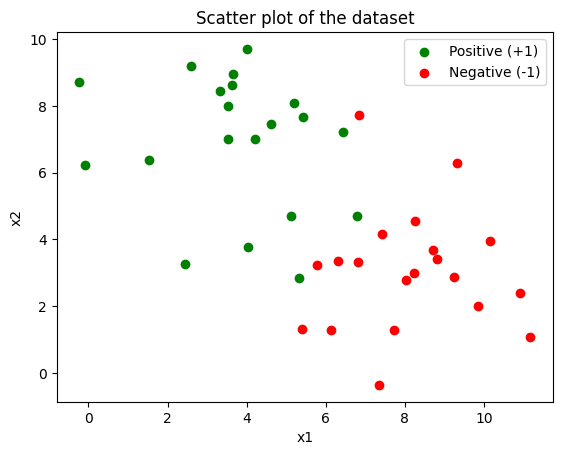

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxopt
from cvxopt import matrix
from cvxopt import solvers
# 1) 读入数据集
data = pd.read_csv('dataset2.csv')
X = data[['x1', 'x2']].values.astype(np.double)
y = data['y'].values.astype(np.double)
# 画出数据集的散点图
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='g', label='Positive (+1)')
plt.scatter(X[y == -1, 0], X[y == -1, 1], c='r', label='Negative (-1)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Scatter plot of the dataset')
plt.legend()
plt.show()

<span style="color:purple">2) 选择一个参数C，求解如下对偶问题（参考课件）：</span>
$$
\begin{align}
\min_\alpha \quad  &\frac{1}{2}\sum_{i=1}^m\sum_{j=1}^m\alpha_i\alpha_jy_iy_j\pmb{x}_i^T\pmb{x}_j-\sum_{i=1}^m\alpha_i \\
s.t. \quad  &\sum_{i=1}^m\alpha_iy_i=0 \\
      &\pmb{0}\leq \pmb{\alpha}\leq C 
\end{align}
$$
* $G:=\begin{bmatrix}
    -1 & 0 & \cdots & 0 \\
    0 & -1 & \cdots & 0 \\
   \vdots & \vdots & \ddots &0 \\
   0 & 0 & 0 & -1 \\
   1 & 0 & \cdots & 0 \\
    0 & 1 & \cdots & 0 \\
   \vdots & \vdots & \ddots &0 \\
   0 & 0 & 0 & 1
   \end{bmatrix}_{2m\times m}=\begin{bmatrix}
    -\pmb{I} \\
    \pmb{I}
   \end{bmatrix},\pmb{I}为单位矩阵,$
* $h:=\begin{bmatrix}
    0 \\
    0 \\
    \vdots \\
    0 \\
    C \\
    C \\
    \vdots \\
    C
   \end{bmatrix}_{2m\times 1}, 即一个m\times 1的零列向量与一个m\times 1的分量全为C的列向量上下拼接$,
* $P,q,A,b$与硬间隔优化问题中的矩阵相同。

In [9]:
# 2) 选择参数C并求解对偶问题
C = 1.0
m = len(y)
Xy = X * y[:, np.newaxis]
P = matrix(Xy @ Xy.T)
q = matrix(-np.ones((m, 1)))
G = matrix(np.vstack([-np.eye(m), np.eye(m)]))
h = matrix(np.hstack([np.zeros(m), C * np.ones(m)]))
A = matrix(y.reshape(1, -1))
b = matrix(0.0)

# 调用求解器
sol = solvers.qp(P, q, G, h, A, b)
alpha = np.array(sol['x'])

     pcost       dcost       gap    pres   dres
 0: -1.1816e+01 -8.2073e+01  4e+02  2e+00  3e-14
 1: -7.7195e+00 -4.7758e+01  7e+01  3e-01  3e-14
 2: -5.7411e+00 -1.4569e+01  1e+01  5e-02  2e-14
 3: -5.6219e+00 -6.8029e+00  2e+00  4e-03  3e-14
 4: -5.8632e+00 -6.2495e+00  5e-01  9e-04  2e-14
 5: -5.9709e+00 -6.0062e+00  4e-02  4e-05  2e-14
 6: -5.9845e+00 -5.9849e+00  4e-04  4e-07  2e-14
 7: -5.9847e+00 -5.9847e+00  4e-06  4e-09  2e-14
Optimal solution found.


<span style="color:purple">3) 求出$\pmb{\omega}^*=\sum_{i=1}^m\alpha_i^*y_i\pmb{x}_i$和$b^*=y_j-\pmb{\omega}^{*T}\pmb{x_j}$, 其中$j$为$\alpha^*$中的一个正分量$0<\alpha_j^*<C$的下标。与硬间隔优化问题同理，应该筛掉非常接近0和非常接近$C$的分量。</span>

In [64]:
# 3) 计算 𝜔 和 𝑏
w = np.sum(alpha * y[:, None] * X, axis=0)

# 找到支持向量的索引并计算 b
sv_idx = (alpha > 1e-4).flatten()
b = np.mean(y[sv_idx] - np.dot(X[sv_idx], w))
print(w)
print(b)

[-3.05175781e-04  6.10351562e-05]
0.0015094698966205966


<span style="color:purple">4) 画出数据集的散点图，给正样本（y为+1）和负样本（y为-1）分别标上不同的颜色，再为支持向量（训练数据中$\alpha_j^*>0$的对应的样本）标上不同的颜色，并画出决策边界$\pmb{\omega}^{*T}\pmb{x}+b=0$和间隔边界$\pmb{\omega}^{*T}\pmb{x}+b=1$与$\pmb{\omega}^{*T}\pmb{x}+b=-1$。</span>

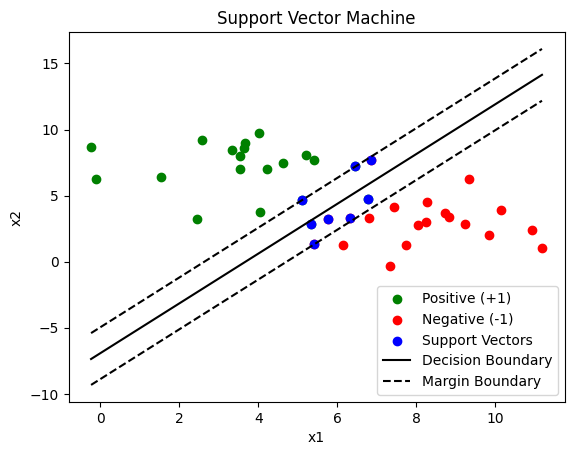

In [11]:
# 4) 画出数据集散点图和决策边界
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='g', label='Positive (+1)')
plt.scatter(X[y == -1, 0], X[y == -1, 1], c='r', label='Negative (-1)')
plt.scatter(X[sv_idx, 0], X[sv_idx, 1], c='b', label='Support Vectors')
x1 = np.linspace(np.min(X[:,0]), np.max(X[:,0]), 100)
x2 = (-w[0]*x1 - b) / w[1]  # Decision boundary
x2_margin1 = (-w[0]*x1 - b + 1) / w[1]  # Margin boundary
x2_margin2 = (-w[0]*x1 - b - 1) / w[1]
plt.plot(x1, x2, 'k', label='Decision Boundary')
plt.plot(x1, x2_margin1, 'k--', label='Margin Boundary')
plt.plot(x1, x2_margin2, 'k--')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Support Vector Machine')
plt.legend()
plt.show()

3.非线性支持向量机与核函数

[Raisin Dataset](https://www.kaggle.com/datasets/muratkokludataset/raisin-dataset)是一个葡萄干的数据集，总共有900个样本，每个样本包含7个(都是连续的)特征以及1个标签，每个标签只有两种可能取值。本次实验已经按照8：2的比例划分成了训练数据集'Raisin_train.csv'以及测试数据集'Raisin_test.csv'，且每个数据集都已经做了特征归一化处理以及把标签的值替换成了+1和-1。

<span style="color:purple">1) 读入训练数据集'Raisin_train.csv',把数据类型都转换成np.double类型。</span>

In [9]:
# ---- Your code here ----
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# 1) 读入训练数据集'Raisin_train.csv'，将数据类型转换为np.double类型
train_data = pd.read_csv('Raisin_train.csv')
X_train = train_data.iloc[:, :-1].values.astype(np.double)
y_train = train_data.iloc[:, -1].values

# 特征归一化处理
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)

<span style="color:purple">2) 选择一个核函数$K(\pmb{x},\pmb{z})$以及参数C，求解如下对偶问题（参考课件）：</span>
$$
\begin{align}
\min_\alpha\quad   &\frac{1}{2}\sum_{i=1}^m\sum_{j=1}^m\alpha_i\alpha_jy_iy_jK(\pmb{x}_i,\pmb{x}_j)-\sum_{i=1}^m\alpha_i \\
s.t. \quad  &\sum_{i=1}^m\alpha_iy_i=0 \\
      &\pmb{0}\leq \pmb{\alpha}\leq C 
\end{align}
$$

相较于软间隔最大化的优化问题，该优化问题仅需要对矩阵$P$做改动。
从以下常用的核函数中选择一个作为该优化问题中的$K$（参数自己进行调整）：
* 线性核：$K(\pmb{x},\pmb{z})=\pmb{x}^T\pmb{z}$
* 多项式核：$K(\pmb{x},\pmb{z})=(\pmb{x}^T\pmb{z}+1)^p$
* 高斯核：$K(\pmb{x},\pmb{z})=exp(-\frac{\parallel \pmb{x}-\pmb{z} \parallel^2}{2\sigma^2})$
* 拉普拉斯核：$K(\pmb{x},\pmb{z})=exp(-\frac{\parallel \pmb{x}-\pmb{z} \parallel}{\sigma})$
* Sigmoid核：$K(\pmb{x},\pmb{z})=tanh(\beta\pmb{x}^T\pmb{z}+\theta)$

则$P是一个m\times m的矩阵，其中P_{ij}=y_iy_jK(\pmb{x_i},\pmb{x_j})$。

In [85]:
# ---- Your code here ----
# 2) 选择核函数 K(x, z) 和参数C，求解对偶问题
# 选择高斯核作为核函数
svm = SVC(kernel='rbf', C=1.0, gamma=0.1)  # gamma是高斯核的一个参数，可以自己调整
svm.fit(X_train, y_train)
alpha = svm.dual_coef_
support_vectors = svm.support_vectors_
y_sv = svm.dual_coef_.reshape(-1, 1) * y_train[svm.support_]

<span style="color:purple">3) 求出$b^*=y_j-\sum_{i=1}^m \alpha_i^*y_iK(\pmb{x_i},\pmb{x_j})$, 其中$j$为$\alpha^*$中的一个正分量$0<\alpha_j^*<C$的下标。</span>

In [88]:
# ---- Your code here ----
# 3) 求解 b*
b_values = []
for j in range(len(support_vectors)):
    b = y_sv[j]
    for i in range(len(support_vectors)):
        b -= alpha[0][i] * y_sv[i] * np.exp(-0.1* np.linalg.norm(support_vectors[i] - support_vectors[j]) ** 2)  # 假设使用高斯核
    b_values.append(b)
b_star = np.mean(b_values)

<span style="color:purple">4) 读入测试数据集'Raisin_test.csv',用分类决策函数$f(\pmb{x})=sign(\sum_{i=1}^m \alpha_i^*y_iK(\pmb{x}_i,\pmb{x})+b^*)$（注意这里的$m,\alpha_i^*,y_i,\pmb{x}_i$是训练集的, $\pmb{x}$是测试集的）进行预测，输出预测准确率。</span>

In [90]:
# ---- Your code here ----
# 4) 读入测试数据集'Raisin_test.csv'，进行预测
test_data = pd.read_csv('Raisin_test.csv')
X_test = test_data.iloc[:, :-1].values.astype(np.double)
y_test = test_data.iloc[:, -1].values
X_test = scaler.transform(X_test)  # 使用相同的缩放参数

# 使用分类决策函数进行预测
y_pred = svm.predict(X_test)

# 计算预测准确率
accuracy = accuracy_score(y_test, y_pred)
print("预测准确率：", accuracy*100,"%")

预测准确率： 85.0 %
